# Visualize the Boundary Detectors in Hierarchical SNN

In [1]:
# visualize the boundary detectors in the hierarchical SNN
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import snntorch.surrogate as surrogate

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dataloader import train_test_val_split, get_dataset_statistics
from models import ThreeLayerSNN, TwoLayer_HierarchicalSNN
from utils.encoding import Rate_Encoder, Current_Encoder
import utils.metrics as metrics


In [2]:
# set seeds
seed = 42
device = 'cpu'
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [3]:
# --- Set Model and Dataset Args --- #
binary = True
model_name = 's_42_two_layer_h_snn_binary_32_64_current_balanced' + '.pth'
weight_folder = '../train_weights'

dataset_configs = {
    "data_file": "/Users/rahul/Documents/G1/BrainInspiredComputing/TermProject/beat_neurokit_1.hdf5",
    "metadata": "/Users/rahul/Documents/G1/BrainInspiredComputing/TermProject/beat_neurokit_1.csv",
    "train_prop": 0.6,
    "val_prop": 0.2,
    "test_prop": 0.2,
    "binary": binary,
    "random_state": seed,
    "balance": True,
    "fourier": False,
}

if binary:
    out_dims = 1
else:
    out_dims = 5


model_configs = {
    'in_dims': 1,
    'out_dims': 1,
    'recurrent_dims': [32, 64],
    'out_act': 'none',
    'out_act_kwargs': {},
    'neuron_options': {
        'beta': 0.9,
        'threshold': 1.0,
        'spike_grad': surrogate.atan(alpha=2), 
        'linear_options':{
            'learning_rule': 'oja',
            'learning_rate': 1e-4,
            'bias': True
        }
    },
    'spike_accumulator': 'sum',
}

In [4]:
# Get Datasets and Dataset Stats
train_dataset, _, test_dataset = train_test_val_split(**dataset_configs)
train_mean, train_std = get_dataset_statistics(train_dataset)
print(len(test_dataset))

/Users/rahul/Documents/G1/BrainInspiredComputing/TermProject/bic_project/dataloader.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label > 0, dtype=torch.float32)


6034


In [5]:
# Load the Model and Configure Encoder
model = TwoLayer_HierarchicalSNN(**model_configs, logging=True)
model_path = os.path.join(weight_folder, model_name)
checkpoint = torch.load(model_path, weights_only=False)

model.load_state_dict(checkpoint['model'])
threshold = checkpoint['threshold']

encoder = Current_Encoder(train_mean, train_std)

/Users/rahul/Documents/G1/BrainInspiredComputing/TermProject/bic_project/dataloader.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label > 0, dtype=torch.float32)


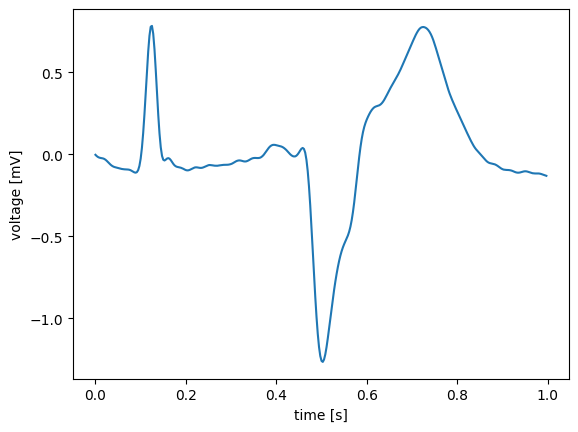

In [19]:
waveform, label = test_dataset.__getitem__(14)
# 5 is really good normal
# 14 is really good abnormal

ts = np.arange(len(waveform)) / 360
plt.plot(ts, waveform);
plt.xlabel('time [s]')
plt.ylabel('voltage [mV]');

In [20]:
with torch.no_grad():
    waveform_for_model = encoder.encode(waveform.unsqueeze(0))
    prediction, b_vals = model(waveform_for_model)
    prediction = int(prediction.squeeze().item() > threshold)

print('Predicted Class: {}'.format(prediction))    

Predicted Class: 1


In [21]:
b_0, b_1 = zip(*b_vals)
b_0 = np.stack(b_0).reshape(len(b_0))
b_1 = np.stack(b_1).reshape(len(b_1))

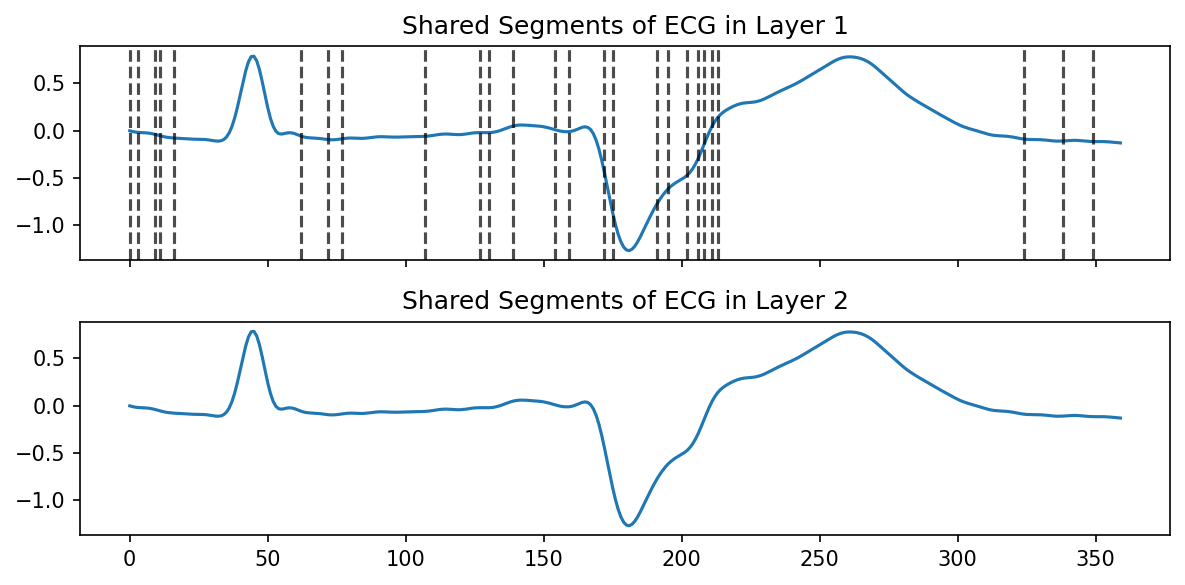

In [22]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 4), gridspec_kw={'height_ratios': [3, 3]}, dpi=150)

x = np.arange(len(b_0))
b_0_indeces = np.where(b_0 == 0)[0]
event_times = x[b_0_indeces]

ax1.plot(x, waveform)
for t in event_times:
    ax1.axvline(t, color='black', linestyle='--', alpha=0.7)

b_1_indeces = np.where(b_1 == 0)[0]
event_times = x[b_1_indeces]

ax2.plot(x, waveform)
for t in event_times:
    ax2.axvline(t, color='black', linestyle='--', alpha=0.7)

ax1.set_title('Shared Segments of ECG in Layer 1')
ax2.set_title('Shared Segments of ECG in Layer 2')

fig.tight_layout()


Text(0.5, 0, 'Time Step')

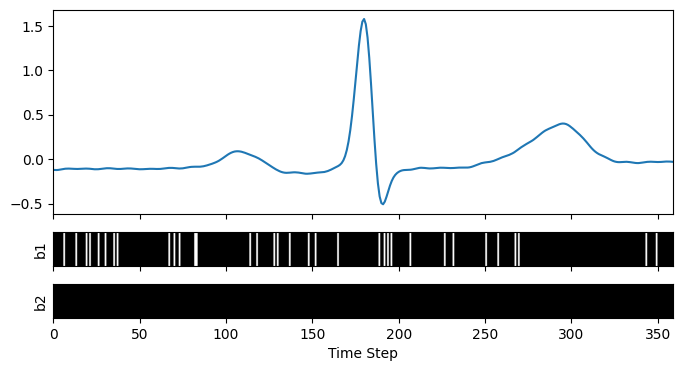

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(8, 4), gridspec_kw={'height_ratios': [3, 0.5, 0.5]})

x = np.arange(len(b_0))

ax1.plot(x, waveform)

ax2.imshow(b_0[np.newaxis, :], aspect='auto', cmap='gray_r', extent=[x[0], x[-1], 0, 1], vmin=0, vmax=1)
ax2.set_yticks([])
ax2.set_xlim(x[0], x[-1])

ax3.imshow(b_1[np.newaxis, :], aspect='auto', cmap='gray_r', extent=[x[0], x[-1], 0, 1], vmin=0, vmax=1)
ax3.set_yticks([])
ax3.set_xlim(x[0], x[-1]);

ax2.set_ylabel('b1')
ax3.set_ylabel('b2')

ax3.set_xlabel('Time Step')